# `normalize` Node Test

The notebook below tests the `normalize` node with the `normalizeNodeTest.yaml` graph. `normalize.py` was manually changed to pipeline the `running_means` (`norm_means` stream) and `running_stds` (`norm_stds` stream) with the normalized data. When testing parameter initialization by CSV file, means were set to 0.0 and standard deviations were set to 1.0 for all channels. I manually changed `func_generator.py` to lower the sampling rate by an order of magnitude. Following graph execution, I ran the `stopGraphAndSaveNWB` supervisor command. The graph went as follows:
```yaml
nodes:
  - name:                               func_generator #.bin
    nickname:                           func_generator
    module:                             ../brand-modules/brand-test
    redis_inputs:                       []
    redis_outputs:                      [func_generator]
    run_priority:                       99
    parameters:             
        sample_rate:                    1000
        n_features:                     96
        n_targets:                      2
        function:                       square
        log:                            INFO

  - name:                               normalize
    nickname:                           normalize
    module:                             ../brand-modules/brand-emory
    redis_inputs:                       [func_generator]
    redis_outputs:                      [normalized_func_generator]
    run_priority:                       99
    parameters:
        log:                            INFO
        sync_key:                       sync
        time_key:                       ts
        input_stream:                   func_generator
        input_dtype:                    float64
        input_key:                      samples
        output_stream:                  normalized_func_generator
        normalization_method:           z_window
        bin_period:                     1
        normalization_update_period:    100
        normalization_duration:         2000
        # normalization_file:             /home/samnt/test_means_stds.csv

derivatives:
  - exportNWB:
        parameters:
            participant_file:       ../Data/t0/t0.yaml
            description:            Testing normalize node
            sync_key:               sync
            time_key:               ts
            streams:
                func_generator:
                    source_node:        func_generator
                    enable:             True
                    sync:               ['i']
                    name:               func_generator
                    samples:            samples
                normalized_func_generator:
                    source_node:        normalize
                    enable:             True
                    sync:               ['i']
                    name:               normalized_binned
                    samples:            samples
                norm_means:
                    source_node:        normalize
                    enable:             True
                    sync:               ['i']
                    name:               normalized_binned
                    samples:            samples
                norm_stds:
                    source_node:        normalize
                    enable:             True
                    sync:               ['i']
                    name:               normalized_binned
                    samples:            samples
```

## Load Data

In [65]:
from pynwb import NWBHDF5IO
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

with NWBHDF5IO('/home/samnt/Projects/Data/0/2022-10-16/RawData/NWB/0_221016T1644_normalizeNodeTest.nwb', 'r') as io:
    nwb = io.read()

    fg = nwb.acquisition['func_generator'].data[:, 0]
    fg_ts = nwb.acquisition['func_generator'].timestamps[:]
    means = nwb.acquisition['norm_means'].data[:, 0]
    stds = nwb.acquisition['norm_stds'].data[:, 0]
    nfg = nwb.acquisition['normalized_func_generator'].data[:, 0]
    nfg_ts = nwb.acquisition['normalized_func_generator'].timestamps[:]

## Tests

The code below plots the raw data, normalized data, means used to normalize the data, and standard deviations used to normalize the data, from the exported NWB file.

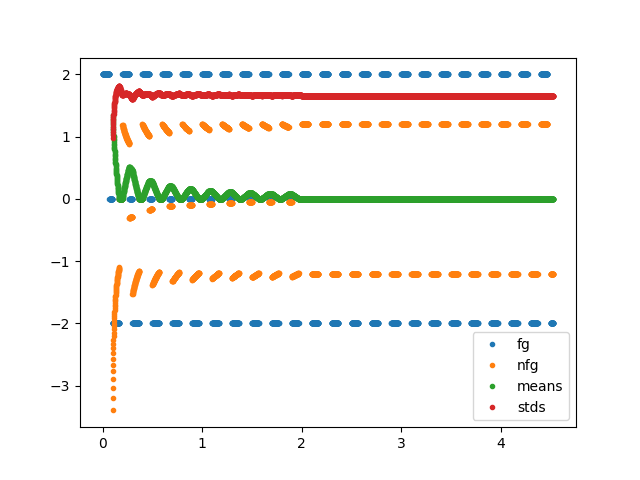

In [66]:
fig, ax = plt.subplots(1)
ax.plot(fg_ts, fg, '.', label='fg')
ax.plot(nfg_ts, nfg, '.', label='nfg')
ax.plot(nfg_ts, means, '.', label='means')
ax.plot(nfg_ts, stds, '.', label='stds')
ax.legend()

Below tests the accuracy during the startup phase for `z_window` when initialized *without* a file.

In [67]:
sample_number_after_init = 1 # start at 1
true_mean = np.mean(fg[0:100+sample_number_after_init])
online_mean = means[sample_number_after_init-1]
print(  f'True mean: {true_mean}\n'
        f'Online mean: {online_mean}\n'
        f'Mean error: {100*np.abs(true_mean-online_mean)/true_mean}%\n')

true_std = np.std(fg[0:100+sample_number_after_init], ddof=1)
online_std = stds[sample_number_after_init-1]
print(  f'True standard deviation: {true_std}\n'
        f'Online standard deviation: {online_std}\n'
        f'Standard deviation error: {100*np.abs(true_std-online_std)/true_std}%\n')

True mean: 1.3465346534653466
Online mean: 1.3465346534653473
Mean error: 4.947023183256212e-14%

True standard deviation: 0.9842321226657502
Online standard deviation: 0.9842321226657504
Standard deviation error: 2.2560186749811932e-14%



Below tests the accuracy during the startup phase for `z_window` when initialized *with* a file.

In [64]:
sample_number_after_init = 80 # start at 1
true_mean = np.mean(fg[0:sample_number_after_init+1])
online_mean = means[sample_number_after_init-1]
print(  f'True mean: {true_mean}\n'
        f'Online mean: {online_mean}\n'
        f'Mean error: {100*np.abs(true_mean-online_mean)/true_mean}%\n')

true_std = np.std(fg[0:sample_number_after_init+1], ddof=1)
online_std = stds[sample_number_after_init-1]
print(  f'True standard deviation: {true_std}\n'
        f'Online standard deviation: {online_std}\n'
        f'Standard deviation error: {100*np.abs(true_std-online_std)/true_std}%\n')

True mean: 1.7037037037037037
Online mean: 1.703703703703704
Mean error: 1.3033052897773576e-14%

True standard deviation: 0.7149203529842406
Online standard deviation: 0.7149203529842406
Standard deviation error: 0.0%



Below tests the accuracy during the window phase for `z_window`.

In [68]:
sample_number_after_init = 2313 # start at 1
true_mean = np.mean(fg[0+sample_number_after_init:2000+sample_number_after_init])
online_mean = means[1900+sample_number_after_init-1]
print(  f'True mean: {true_mean}\n'
        f'Online mean: {online_mean}\n'
        f'Mean error: {100*np.abs(true_mean-online_mean)/true_mean}%\n')

true_std = np.std(fg[0+sample_number_after_init:2000+sample_number_after_init], ddof=1)
online_std = stds[1900+sample_number_after_init-1]
print(  f'True standard deviation: {true_std}\n'
        f'Online standard deviation: {online_std}\n'
        f'Standard deviation error: {100*np.abs(true_std-online_std)/true_std}%\n')

True mean: 0.004
Online mean: 0.0040000000000000955
Mean error: 2.3852447794681098e-12%

True standard deviation: 1.6569117895467969
Online standard deviation: 1.656911789546797
Standard deviation error: 1.3401112016093842e-14%



Below emulates the online routine to assist with debugging

In [11]:
n_samples=1
running_means=fg[0]
first=fg[0]
m_2=0.0
running_vars=0.0
for i, s in enumerate(fg):
    if i == 0:
        continue
    n_samples=np.min([i+1, 2000])
    if i+1 > 2000:
        # https://jonisalonen.com/2014/efficient-and-accurate-rolling-standard-deviation/
        new_means = running_means + (s - first)/n_samples
        running_vars += (s-first)*(s-new_means+first-running_means)/(n_samples-1)
    else:
        # Welford's online variance algorithm https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
        new_means = running_means + (s - running_means)/n_samples
        m_2 += (s-running_means)*(s-new_means)
        running_vars = m_2 / (n_samples-1)
    
    running_means = new_means
    